# 98point6 Data Science Homework

## by Vinay Kumar Ranganath Babu

### Technology used: Python
### Libraries used: pandas,matplotlib,numpy,requests,json,csv
### Visualizations: bar-plot

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import requests
import json
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Importing games data into pandas dataframe
games = pd.read_csv("game_data.csv")

# Exploratory Data Analysis

In [3]:
# First 5 rows of games data
games.head()

,game_id,player_id,move_number,column,result
0,0,2667,1,1,NaN
1,0,432,2,1,NaN
2,0,2667,3,2,NaN
3,0,432,4,2,NaN
4,0,2667,5,3,NaN


In [4]:
# Total number of games played
print(len(games['game_id'].unique()))

10000


We have the data of 10000 games which were played.

In [5]:
# Wins vs Draws
print(games['result'].value_counts())

win     5296
draw    4704
Name: result, dtype: int64


Out of 10000 games being played, number of wins are 5296 and 4704 were drawn. Win percentage = ~53%.

In [6]:
# Total number of players
print(len(games['player_id'].unique()))

4896


We have the data of 4896 different players who played these games.

# Feature Extarction

In [7]:
# Create a new csv file named 'players' in write mode
f = csv.writer(open("players.csv", "wb+"))
f.writerow(["player_id", "country"])

# Get the data using requests library in json format and write the data into csv file
for i in range(0,524):
    json_data = requests.get("https://x37sv76kth.execute-api.us-west-1.amazonaws.com/prod/users?page=" + str(i))
    data = json_data.json()
    for entry in data:
        f.writerow([entry['id'],entry['data']['nat']])

In [8]:
# Importing players data into pandas dataframe
players = pd.read_csv("players.csv")

# Exploratory Data Analysis

In [9]:
# First 5 rows of players data
players.head()

,player_id,country
0,0,IE
1,1,ES
2,2,GB
3,3,CH
4,4,TR


In [10]:
# Number of players
print(len(players['player_id'].unique()))

4672


We have a total of 4672 players information.

In [11]:
# Countries vs Players
print("Total number of countries:",len(players['country'].unique()))
print(players['country'].value_counts())

('Total number of countries:', 17)
IE    336
CH    329
US    324
TR    315
CA    312
NL    312
ES    306
FI    302
FR    285
AU    278
DK    276
NZ    269
DE    264
GB    259
BR    254
IR    251
Name: country, dtype: int64


Hence the players data have 'Republic of Ireland' players the most and Iran players data the least.

# Question 1 - Out of all the games, what is the percentile rank of each column used as the first move in a game? That is, when the first player is choosing a column for their first move, which column most frequently leads to that player winning the game?

In [12]:
# Merge 2 dataframes (move_number = 1 and result = win) on field game_id,player_id via inner join 
# and get different columns value counts
wins = (games[games['move_number'] == 1]).merge((games[games['result'] == 'win'][['game_id','player_id','result']]),
                                       on=['game_id','player_id'],
                                       how='inner')['column'].value_counts()


print(wins)

4    794
1    776
2    656
3    649
Name: column, dtype: int64


In [13]:
percentiles = np.argsort(np.argsort(wins.values)) * 100. / (len(wins.values) - 1)
print(percentiles)

[ 100.           66.66666667   33.33333333    0.        ]


Hence column 4 has the majority wins when it is used as a first move during the game.

## Is there an advantage of making a first move to ensure victory?

In [14]:
df1 = (games[games['move_number'].isin([1,2])]).merge((games[games['result'].isin(['win','draw'])])[['game_id','player_id','result']],
                                                      on=['game_id','player_id'],
                                                      how='left')
del df1['result_x']
print(len(df1[(df1['result_y'] == 'win') & (df1['move_number'] == 1)]))
print(len(df1[(df1['result_y'] == 'win') & (df1['move_number'] == 2)]))

2875
2421


We observe that the wins are closest to each other. 

# Question 2 - How many games has each nationality of player played?

In [15]:
# Merge 2 dataframes (move_number = 1,2 and players) on field player_id via inner join 
# and get different countries value counts
games_played = (games[games['move_number'].isin([1,2])]).merge(players,
                                                    on='player_id',
                                                    how='inner')['country'].value_counts()
print(games_played)

IE    1420
CH    1337
US    1316
TR    1272
CA    1243
ES    1222
NL    1221
FI    1209
AU    1128
DK    1113
DE    1066
FR    1048
NZ    1047
IR    1025
GB    1016
BR     992
Name: country, dtype: int64


Hence players coming from Republic of Ireland have played the highest and Brazil players have played the lowest.

# Question 3 - Visualize the win percentage by country

In [16]:
# Merge 2 dataframes (result = win and players) on field player_id via inner join 
# and get different countries value counts
wins = (games[games['result'] == 'win']).merge(players,
                                      on='player_id',
                                      how='inner')['country'].value_counts()

In [17]:
# Construct a dataframe with country names, their wins and the number of games they have played
winper = pd.concat([pd.DataFrame(wins.sort_index().index),pd.DataFrame(wins.sort_index().values),pd.DataFrame(games_played.sort_index().values)],axis=1)
winper.columns = ['country','wins','played']
winper['win%'] = (winper['wins'] / winper['played']) * 100

# Display the dataframe
winper = winper.round(2).sort(['win%'])

/home/vinay/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


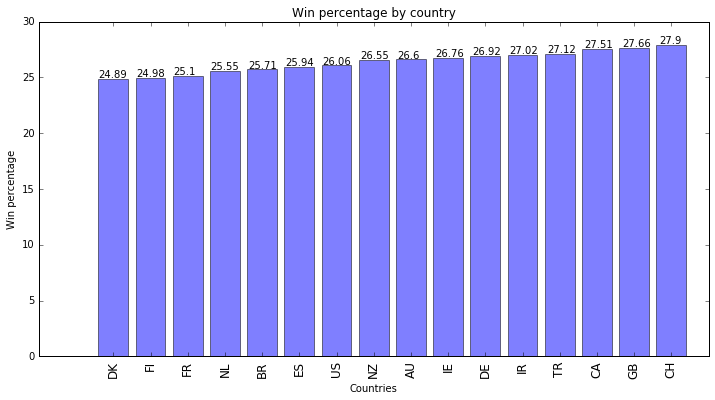

In [18]:
# Bar-Plot of win percentages
X = np.arange(len(winper['country']))
X_ticks_labels = winper['country']
Y = winper['win%']

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(X,Y,align='center',alpha=0.5)
ax.set_xticks(X)
ax.set_xticklabels(X_ticks_labels,rotation='vertical',fontsize=12)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title("Win percentage by country")
plt.xlabel("Countries")
plt.ylabel("Win percentage")
plt.show()

Switzerland have the highest win percentage with 27.9% and Denmark have the lowest with 24.89%.

# Question 4 - Does the entire game is determined by the first few moves?

## Hypothesis: Compare first few moves pattern versus the whole game's moves pattern

### First few moves patterns

In [19]:
# Merge 2 dataframes (move number = 1-6 and result = draw,win) on field game_id via inner join 
df2 = games.merge(games[games['result'].isin(['draw','win'])][['game_id','result','move_number']],
                                                                       on='game_id',
                                                                       how='inner')
del df2['result_x']
df2.head()

,game_id,player_id,move_number_x,column,result_y,move_number_y
0,0,2667,1,1,draw,16
1,0,432,2,1,draw,16
2,0,2667,3,2,draw,16
3,0,432,4,2,draw,16
4,0,2667,5,3,draw,16


In [20]:
df2['percentage'] = (df2['move_number_x'] / df2['move_number_y']) * 100

first_few_moves = df2[df2['percentage'] <= 40.0]

abc = first_few_moves.groupby(['game_id','result_y'])['column'].apply(list)

dff = pd.concat([pd.DataFrame(abc.index.get_level_values('result_y')),pd.DataFrame(abc.values)],axis=1)

# Column names for the dataframe df
dff.columns = ['result','patterns']

# First 5 rows of the dataframe
dff.head()

,result,patterns
0,win,"[2, 1, 3, 3]"
1,win,"[4, 2, 2, 2, 1, 1]"
2,draw,"[1, 1, 2, 2, 3, 1]"
3,draw,"[2, 4, 4, 4, 4, 3]"
4,win,"[4, 1, 2, 1, 3]"


In [21]:
# Function to convert list of numbers into sequence
def list_to_str(lst):
    ss = ""
    for i in lst:
        ss += str(i)
    return ss  

In [22]:
# Create a new column namd 'pattern' by applying the function list_to_str to every row in df
dff['pattern'] = dff['patterns'].apply(list_to_str)

# Delete the column 'patterns'
del dff['patterns']

# Create a Series grouping by the pattern and the corresponding result for that pattern
dff.groupby('pattern')['result'].apply(list)

pattern
11        [win, win, win, win, win, win, win, win, win, ...
111                                                   [win]
1111                         [win, win, win, win, win, win]
11112                                                 [win]
111122                                    [draw, win, draw]
111123                                          [draw, win]
111124                               [win, win, draw, draw]
11113                                                 [win]
111132                               [win, draw, win, draw]
111133                                   [draw, draw, draw]
111134                                          [win, draw]
111142                              [draw, draw, win, draw]
111143                   [draw, draw, win, win, draw, draw]
111144                                    [draw, win, draw]
1112               [win, win, win, win, win, win, win, win]
111212                                               [draw]
111213                          

We can clearly see from the above data that there is no fixed result matching the initial set of moves/patterns. For example if the initial 6 moves are '111143', then we observe the results of 6 games to be 'draw, draw, win, win, draw, draw'. This is the same case with the other patterns as well. Hence we do not have a concrete evidence that initial set of moves decide the results. However, let us dig deep by seeing the whole game's pattern.

In [23]:
# Number of unique patterns
print(sum(dff['pattern'].value_counts() == 1))

# Percentage of unique patterns
print(sum(dff['pattern'].value_counts() == 1) / float(len(games['game_id'].unique())) * 100)

1622
16.22


~16% of the games are different from each other.

### Whole games patterns

In [24]:
games_all_moves = games.merge(games[games['result'].isin(['draw','win'])][['game_id','result']],
                                                                       on='game_id',
                                                                       how='inner')

# Construct a dataframe with 2 columns (result and pattern of first 6 moves)
abc = games_all_moves.groupby(['game_id','result_y'])['column'].apply(list)
df3 = pd.concat([pd.DataFrame(abc.index.get_level_values('result_y')),pd.DataFrame(abc.values)],axis=1)

# Colum names for the dataframe df
df3.columns = ['result','patterns']

# Create a new column namd 'pattern' by applying the function list_to_str to every row in df
df3['pattern'] = df3['patterns'].apply(list_to_str)

# Delete the column 'patterns'
del df3['patterns']

# Create a Series grouping by the pattern and the corresponding result for that pattern
df3.groupby('pattern')['result'].apply(list)

pattern
111122242343334      [win]
11112232334          [win]
1111223323344442    [draw]
1111224344432233    [draw]
1111233322432444    [draw]
111123422243334      [win]
1111242223333444    [draw]
1111242232333444    [draw]
111124343434         [win]
1111244243432323     [win]
111124424423233      [win]
11112444333232       [win]
1111323334422442    [draw]
1111323424332424     [win]
1111323444422323    [draw]
111132422334         [win]
1111324444332322     [win]
111133234            [win]
111133243242         [win]
1111333234444222    [draw]
111133332422         [win]
1111334243342224    [draw]
1111334243442232    [draw]
1111342222333444    [draw]
11113423244332       [win]
1111343223342424     [win]
1111422322434334    [draw]
1111423432232434    [draw]
1111424222344333    [draw]
1111424424223333     [win]
                     ...  
4444123233311212     [win]
4444131112232233    [draw]
4444131222112333    [draw]
4444133332211221    [draw]
4444211133221332    [draw]
4444212112332133    

In [25]:
# Number of unique patterns
print(sum(df3['pattern'].value_counts() == 1))

# Percentage of unique patterns
print(sum(df3['pattern'].value_counts() == 1) / float(len(games['game_id'].unique())) * 100)

9890
98.9


* We can see from the first few patterns that the results are not the same (results are the combination of wins and draws).
* A pattern for intial set of moves can have multiple same victories. However we cannot predict the result only with these as we can see that the result varies after all the moves are handled.
* There are a total of 9890 unique patterns the way the game is played. This also gives us an indication that the result of the game is not just decided on the initial set of moves.
* Hence ~99% of the games are different from each other (Have different pattern of moves). This is a strong conclusion that the initial set of moves do not decide on the game.
* Initially when we considered first few moves (6 moves), we had good 91% of the games which were similar to each other in their moves patterns. It would be so easy to conclude with such a big number that the results could be predicted. However, when we saw the entire set of moves, this number decreased to just 1%!!!

#### Tool

In [26]:
# Calculate the sum of wins/draws according to the pattern
sum((df3['pattern'].str.startswith("12233")) & (df3['result'] == 'win'))

7

In [27]:
df4 = games[games['result'].isin(['draw','win'])]
print("Number of wins when moves exceeding 10 moves:", len(df4[(df4['move_number'] > 10) & (df4['result'] == 'win')]))
print("Number of draws when moves exceeding 10 moves:", len(df4[(df4['move_number'] > 10) & (df4['result'] == 'draw')]))
print("Number of wins when moves not exceeding 10 moves:", len(df4[(df4['move_number'] <= 10) & (df4['result'] == 'win')]))
print("Number of draws when moves not exceeding 10 moves:", len(df4[(df4['move_number'] <= 10) & (df4['result'] == 'draw')]))

('Number of wins when moves exceeding 10 moves:', 4631)
('Number of draws when moves exceeding 10 moves:', 4704)
('Number of wins when moves not exceeding 10 moves:', 665)
('Number of draws when moves not exceeding 10 moves:', 0)
